In [15]:
import qutip as qt
from qutip.qip.operations import rx
import numpy as np

$|\psi\rangle = e^{-i\phi/2}\cos(\theta/2)|0\rangle + e^{i\phi/2}\sin(\theta/2)|1\rangle$

In [16]:
def to_spherical(state):
    r0 = np.abs(state[0])
    ϕ0 = np.angle(state[0])
    r1 = np.abs(state[1])
    ϕ1 = np.angle(state[1])
    r = np.sqrt(r0 ** 2 + r1 ** 2)
    θ = 2 * np.arccos(r0 / r)
    ϕ = ϕ1 - ϕ0
    return [r, θ, ϕ]

def to_cartesian(polar):
    r = polar[0]
    θ = polar[1]
    ϕ = polar[2]
    x = r * np.sin(θ) * np.cos(ϕ)
    y = r * np.sin(θ) * np.sin(ϕ)
    z = r * np.cos(θ)
    return [x, y, z]

In [17]:
# SO(3) rotation matrix contains a total of three parameters theta,  phi, delta
def rn_so3(state, θ, ϕ, δ):
    rn_mat = qt.Qobj(
        [[np.cos(δ/2) - (0+1j)*np.cos(θ)*np.sin(δ/2),
          -(0+1j)*np.exp(-(0+1j)*ϕ)*np.sin(δ/2)*np.sin(θ)],
         [-(0+1j)*np.exp((0+1j)*ϕ)*np.sin(δ/2)*np.sin(θ),
          np.cos(δ/2) + (0+1j)*np.cos(θ)*np.sin(δ/2)]]
        )
    r_state = (rn_mat*state)*(rn_mat*state).dag()
    return r_state

#SU(2) rotation
def rn_su2(state, θ, nx, ny, nz):
    Ψ = [state.data[0,0], state.data[1,0]]
    arr = to_spherical(Ψ)
    s_θ = arr[1]
    s_ϕ = arr[2]
    M_q = np.eye(2) / 2 + 1/2 * (np.sin(s_θ)*np.cos(s_ϕ)*qt.sigmax() + np.sin(s_θ)*np.sin(s_ϕ)*qt.sigmay() + np.cos(s_θ)*qt.sigmaz())
    U_n = qt.qeye(2)*np.cos(θ/2) -1j*(nx*qt.sigmax()+ny*qt.sigmay()+nz*qt.sigmaz())*np.sin(θ/2)
    r_state = U_n*M_q*U_n.dag()
    return r_state

#SU(2) composed rotation
def rn_su2_composed(state, θ
, ϕ, δ):
    Ψ = [state.data[0,0], state.data[1,0]]
    arr = to_spherical(Ψ)
    s_θ = arr[1]
    s_ϕ = arr[2]
    M_q = np.eye(2) / 2 + 1/2 * (np.sin(s_θ)*np.cos(s_ϕ)*qt.sigmax() + np.sin(s_θ)*np.sin(s_ϕ)*qt.sigmay() + np.cos(s_θ)*qt.sigmaz())
    U_n = qt.Qobj(
        [[np.cos(ϕ/2)*np.exp(1j/2*(δ+θ)), 1j*np.sin(ϕ/2)*np.exp(1j/2*(θ-δ))],
         [1j*np.sin(ϕ/2)*np.exp(1j/2*(δ-θ)), np.cos(ϕ/2)*np.exp(-1j/2*(θ+δ))]]
        )
    r_state = U_n*M_q*U_n.dag()
    return r_state

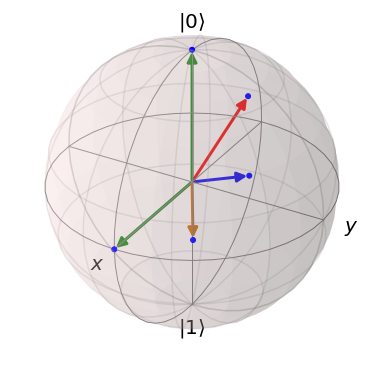

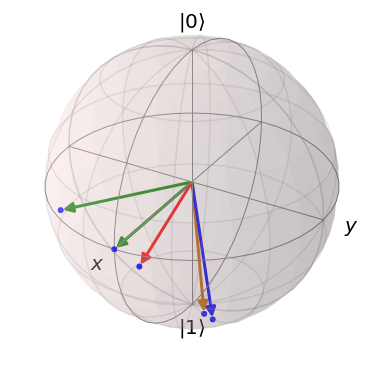

In [45]:
b_so3 = qt.Bloch()
b_so3.clear()
b_so3.make_sphere()
b_su2 = qt.Bloch()
b_su2.clear()
b_su2.make_sphere()

states_so3 = []
points_so3 = []
states_su2 = []
points_su2 = []

alpha = 1/np.sqrt(2)
beta = 1/np.sqrt(2)
s = np.array([alpha,beta])
state = qt.Qobj(s)
states_so3.append(state)
states_su2.append(state)

Ψ = [complex(alpha, 0), complex(beta, 0)]
polar = to_spherical(Ψ)
pnt = to_cartesian(polar)
points_so3.append(pnt)
points_su2.append(pnt)

rotated_so3 = state
rotated_su2 = state
for i in range(0,4):
    rotated_so3 = rn_so3(rotated_so3, np.pi/4, 0, np.pi/4)
    pnt_so3 = [(qt.sigmax()*rotated_so3).tr(), (qt.sigmay()*rotated_so3).tr(), (qt.sigmaz()*rotated_so3).tr()]
    states_so3.append(rotated_so3)
    points_so3.append(pnt_so3)

    #rotated_su2 = rn_su2(rotated_su2, np.pi/4, 0, 0, 1)

    #um z
    #rotated_su2 = rn_su2_composed(rotated_su2, 0, 0, -np.pi/8)
    #um y
    #rotated_su2 = rn_su2_composed(rotated_su2, 0, np.pi/8, 0)    
    #um z
    #rotated_su2 = rn_su2_composed(rotated_su2, -np.pi/8, 0, 0)
    
    rotated_su2 = rn_su2_composed(rotated_su2, 0, 0, -np.pi/4)
    rotated_su2 = rn_su2_composed(rotated_su2, 0, np.pi/4, 0)
    pnt_su2 = [(qt.sigmax()*rotated_su2).tr(), (qt.sigmay()*rotated_su2).tr(), (qt.sigmaz()*rotated_su2).tr()]
    states_su2.append(rotated_su2)
    points_su2.append(pnt_su2)

b_so3.add_states(states_so3)
np_points_so3 = np.array(points_so3)
b_so3.add_points([np_points_so3[:,0], np_points_so3[:,1], np_points_so3[:,2]])
b_so3.show()

b_su2.add_states(states_su2)
np_points_su2 = np.array(points_su2)
b_su2.add_points([np_points_su2[:,0], np_points_su2[:,1], np_points_su2[:,2]])
b_su2.show()